# Contents <a id='back'></a>

* [Introduction and Data Description](#intro)
* [Stage 1. 1. Prepare the data](#data_prep)
     * [1.2 Check that recovery is calculated correctly](#recovery)
     * [1.3 Analyze the features not available in the test set. ](#test_features)
     * [1.4 Data Preprocessing ](#1.4)
* [Stage 2. Analyze the data](#2.0)
    * [2.1 Take note of how the concentrations of metals (Au, Ag, Pb) ](#2.1)
    * [2.2 Compare the feed particle size distributions ](#2.2)
    * [2.3 Consider the total concentrations of all substances](#2.3)
    
    
    
    
* [Stage 3 Build the model](#3.0)
    * [3.1 Write a function to calculate sMAPE for scoring](#3.1)
    * [3.2 DummyRegressor baseline and sanity check](#3.2)
    * [3.3 LinearRegresion model](#3.3)
    * [3.4 RandomForestRegressor model](#3.4)
    
   
* [Final Conclusions](#end)

## Introduction:  <a id='intro'></a>

I am putting together a prototype for a gold miner named Zyfra that predicts the amount of gold recovered from gold ore. I am given data on extraction and purification.
The model will help to optimize the production and eliminate unprofitable parameters.


We need to predict two values:

    rougher concentrate recovery: * rougher.output.recovery

    final concentrate recovery: * final.output.recovery

The final metric includes the two values:

sMAPE


#### Data description:
##### Feature naming
Here's how you name the features:

[stage].[parameter_type].[parameter_name]
Example: 

    rougher.input.feed_ag
Possible values for [stage]:

    rougher — flotation
    primary_cleaner — primary purification
    secondary_cleaner — secondary purification
    final — final characteristics
Possible values for [parameter_type]:

    input — raw material parameters
    output — product parameters
    state — parameters characterizing the current state of the stage
    calculation — calculation characteristics
    
 [Back to Contents](#back)
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats as st
import seaborn as sb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error #mae
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import *
from sklearn.model_selection import *
from sklearn.ensemble import *

## 1. Prepare the data: <a id='data_prep'></a>

## 1.1. Open the files and look into the data.

In [2]:
try:
    gold_train = pd.read_csv('gold_recovery_train.csv') #read csv file stored locally on my laptop
except:
    gold_train = pd.read_csv('/datasets/gold_recovery_train.csv') #make an exception for when I upload the project to Practicum
try:
    gold_test = pd.read_csv('gold_recovery_test.csv') #read csv file stored locally on my laptop
except:
    gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
try:
    gold_full = pd.read_csv('gold_recovery_full.csv') #read csv file stored locally on my laptop
except:
    gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')


In [3]:
display(gold_train.head(10)) #Lets look at the data
gold_train.shape

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


(16860, 87)

In [4]:
gold_train.shape

(16860, 87)

In [5]:
gold_full.shape

(22716, 87)

In [6]:
gold_test.shape

(5856, 53)

Looking at the shapes of the 3 datasets and I can see columns are missing from the test set that we will need to populate before testing our model. The full set contains both the test set and the training set and we can see both add up to number of rows in the full set. 

In [7]:
gold_full['rougher.output.recovery'].head() #Taking a quick look at targets

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

In [8]:
gold_full['final.output.recovery'].head() #Looking at targets

0    70.541216
1    69.266198
2    68.116445
3    68.347543
4    66.927016
Name: final.output.recovery, dtype: float64

## 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?  <a id='test_features'></a>

[Back to Contents](#back)

In [9]:
full_columns = list(gold_full.columns) 

In [10]:
test_columns = list(gold_test.columns)

In [11]:
# find the missing and additional elements in the 2 lists of columns
print("Missing values in test_columns:")
print((set(full_columns).difference(test_columns)))
print()
print("Number of Missing columns:")
print(len(set(full_columns).difference(test_columns)))

Missing values in test_columns:
{'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'rougher.output.recovery', 'secondary_cleaner.output.tail_pb', 'rougher.output.concentrate_sol', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'primary_cleaner.output.tail_sol', 'rougher.output.tail_sol', 'final.output.tail_pb', 'rougher.output.tail_ag', 'rougher.output.concentrate_ag', 'final.output.recovery', 'final.output.tail_au', 'primary_cleaner.output.tail_au', 'final.output.concentrate_au', 'secondary_cleaner.output.tail_au', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.tail_pb', 'primary_cleaner.output.concentrate_pb', 'rougher.output.concentrate_pb', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'final.output.tail_sol', 'rougher.calculation.sulfate_to_au_concentrate', 'final.output.tail_ag', 'secondary_cleaner.outp

##### After analyzing the 34 features missing in the test set I can see that none of the the "final" stage features are included. Also none of the parameter types of "output" are included in the test set. The targets rougher.output.recovery and final.output.recovery are not included in the test data-frame either. All missing values are of type float64.

In [12]:
gold_test.head(10)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


In [13]:
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [14]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [15]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


##### As you can see above in the train and full sets all missing values in the test set are float64.

### 1.4 DATA PREPROSESSING <a id='1.4'></a>

[Back to Contents](#back)

Some issues I see at first glance is that the date is type "object" we need to convert it to datetime. We need to sort the entire dataset by date to make sure rows that are next to each other are also close together in time. Also there are NaN values that we need to deal with case by case. 

In [16]:
#Change date to type datetime, not setting as index since it not easy to use loc and iloc to slice df when index is type datetime
for df in [gold_full, gold_train, gold_test]:
  if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
  

In [17]:
#need to make sure that we are sure that sets are sorted by date time since we will use rows directly above to fill in NaNs
gold_full.sort_values(inplace=True, by='date') #we need them to be sorted so that we we can fill NaN values with close by date and time values.
gold_test.sort_values(inplace=True, by='date')
gold_train.sort_values(inplace=True, by='date')
gold_train.dtypes #checking if data type was changed to datetime

date                                          datetime64[ns]
final.output.concentrate_ag                          float64
final.output.concentrate_pb                          float64
final.output.concentrate_sol                         float64
final.output.concentrate_au                          float64
                                                   ...      
secondary_cleaner.state.floatbank5_a_level           float64
secondary_cleaner.state.floatbank5_b_air             float64
secondary_cleaner.state.floatbank5_b_level           float64
secondary_cleaner.state.floatbank6_a_air             float64
secondary_cleaner.state.floatbank6_a_level           float64
Length: 87, dtype: object

In [18]:
gold_full.head(5) #date time looks right for the first columns

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


I noticed is that the names of the features do not follow the snake naming conventions. I will replace all periods with an underscore below.

In [19]:
new_columns_full = [] #Changing names for using periods to using underscores
for i in range(gold_full.columns.size):
    new_columns_full.append (gold_full.columns[i].replace(".","_"))
    
print(new_columns_full)

['date', 'final_output_concentrate_ag', 'final_output_concentrate_pb', 'final_output_concentrate_sol', 'final_output_concentrate_au', 'final_output_recovery', 'final_output_tail_ag', 'final_output_tail_pb', 'final_output_tail_sol', 'final_output_tail_au', 'primary_cleaner_input_sulfate', 'primary_cleaner_input_depressant', 'primary_cleaner_input_feed_size', 'primary_cleaner_input_xanthate', 'primary_cleaner_output_concentrate_ag', 'primary_cleaner_output_concentrate_pb', 'primary_cleaner_output_concentrate_sol', 'primary_cleaner_output_concentrate_au', 'primary_cleaner_output_tail_ag', 'primary_cleaner_output_tail_pb', 'primary_cleaner_output_tail_sol', 'primary_cleaner_output_tail_au', 'primary_cleaner_state_floatbank8_a_air', 'primary_cleaner_state_floatbank8_a_level', 'primary_cleaner_state_floatbank8_b_air', 'primary_cleaner_state_floatbank8_b_level', 'primary_cleaner_state_floatbank8_c_air', 'primary_cleaner_state_floatbank8_c_level', 'primary_cleaner_state_floatbank8_d_air', 'pri

In [20]:
gold_full.columns = new_columns_full #Changing the column names

In [21]:
gold_full.head()

,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [22]:
new_columns_test = [] #Doing the same column change for train df and test df.
for i in range(gold_test.columns.size):
    new_columns_test.append (gold_test.columns[i].replace(".","_"))
    
print(new_columns_test)

['date', 'primary_cleaner_input_sulfate', 'primary_cleaner_input_depressant', 'primary_cleaner_input_feed_size', 'primary_cleaner_input_xanthate', 'primary_cleaner_state_floatbank8_a_air', 'primary_cleaner_state_floatbank8_a_level', 'primary_cleaner_state_floatbank8_b_air', 'primary_cleaner_state_floatbank8_b_level', 'primary_cleaner_state_floatbank8_c_air', 'primary_cleaner_state_floatbank8_c_level', 'primary_cleaner_state_floatbank8_d_air', 'primary_cleaner_state_floatbank8_d_level', 'rougher_input_feed_ag', 'rougher_input_feed_pb', 'rougher_input_feed_rate', 'rougher_input_feed_size', 'rougher_input_feed_sol', 'rougher_input_feed_au', 'rougher_input_floatbank10_sulfate', 'rougher_input_floatbank10_xanthate', 'rougher_input_floatbank11_sulfate', 'rougher_input_floatbank11_xanthate', 'rougher_state_floatbank10_a_air', 'rougher_state_floatbank10_a_level', 'rougher_state_floatbank10_b_air', 'rougher_state_floatbank10_b_level', 'rougher_state_floatbank10_c_air', 'rougher_state_floatbank1

In [23]:
gold_test.columns = new_columns_test #change columns to snake format since dots can mess up the coding

In [24]:
gold_test

,date,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5852,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5853,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5854,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [25]:
new_columns_train = []
for i in range(gold_train.columns.size):
    new_columns_train.append (gold_train.columns[i].replace(".","_"))
    

In [26]:
gold_train.columns = new_columns_train

In [27]:
gold_train.head() # making sure the columns are now in snake format

,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


#### Delete or fill in all NaN values in the data frames.

In [28]:
display (gold_train.shape[0]) #Checking total number of rows to compare after I drop NaN
gold_full.shape[0]

16860

22716

In [29]:
percent_nan =  gold_train['final_output_recovery'].isna().sum()/gold_train.shape[0]
print(percent_nan*100) #percent of nan values in final_output_recovery for the data set

9.02135231316726


In [30]:
percent_nan =  gold_train['rougher_output_recovery'].isna().sum()/gold_train.shape[0]
print(percent_nan*100) #percent of nan values in rougher_output_recovery

15.26097271648873


In [31]:
percent_nan =  gold_full['final_output_recovery'].isna().sum()/gold_full.shape[0]
print(percent_nan*100) #percent of nan values in final_output_recovery for the data set

8.641486177143863


In [32]:
percent_nan =  gold_full['rougher_output_recovery'].isna().sum()/gold_full.shape[0]
print(percent_nan*100) #percent of nan values in rougher_output_recovery

13.730410283500616


The highest percentage of NaN values is in the training set for rougher_output_recovery target and it came in at 15% of our total dataframe observations. We cannot train a model if we don't have targets 

In [33]:
gold_train = gold_train[~gold_train['final_output_recovery'].isna()] #Delete all nan values in targets since they are not a big percentage of total
gold_train = gold_train[~gold_train['rougher_output_recovery'].isna()] #Delete all nan values in targets since they are not a big percentage of total

In [34]:
gold_train.shape[0] #can see that about 2711 rows were deleted which represents a total of 16%. Onward!

14149

In [35]:
display(gold_train['final_output_recovery'].isna().sum())
display(gold_train['rougher_output_recovery'].isna().sum())


0

0

In [36]:
gold_full = gold_full[~gold_full['final_output_recovery'].isna()] #Delete all nan values in targets since they are not a big percentage of total
gold_full = gold_full[~gold_full['rougher_output_recovery'].isna()] #Delete all nan values in targets since they are not a big percentage of total


In [37]:
gold_full.shape[0] #About 14% of rows were dropped from the full set not too bad.

19439

In [38]:
display(gold_full['final_output_recovery'].isna().sum())
display(gold_full['rougher_output_recovery'].isna().sum()) #NO MORE NaN in the targets

0

0

#### Now we deal with NaN values in the rest of the features. 

There are a considerable number of NaN values especially in the rougher stage. We will fill them in with values that are in the row right above since the project descriptions says: "Parameters that are next to each other in terms of time are often similar."

In [39]:
gold_train = gold_train.fillna(method='ffill')
gold_train.reset_index(drop=True, inplace=True) #Drop old index after deleting observations with NaN in targets

In [40]:
gold_train.info() # Checking to make sure every single feature has zero NaN or Null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final_output_concentrate_ag                         14149 non-null  float64       
 2   final_output_concentrate_pb                         14149 non-null  float64       
 3   final_output_concentrate_sol                        14149 non-null  float64       
 4   final_output_concentrate_au                         14149 non-null  float64       
 5   final_output_recovery                               14149 non-null  float64       
 6   final_output_tail_ag                                14149 non-null  float64       
 7   final_output_tail_pb                                14149 non-null  float64       
 8   final_

In [41]:
gold_train['final_output_recovery'].isna().sum() #Double checking for NaN values in each target separatly

0

In [42]:
gold_train['final_output_recovery'].isna().sum() #Targets are crucial for the model to perform well so we can't have NaN

0

In [43]:
#Do the same for the full set
gold_full = gold_full.fillna(method='ffill') #filling in all NaN for all features with the closest row above
gold_full.reset_index(drop=True, inplace=True)

In [44]:
gold_full.isna().sum().sort_values() #Since this is sorted we can see there are no NaN values left anywhere

date                                                  0
rougher_state_floatbank10_e_level                     0
rougher_state_floatbank10_e_air                       0
rougher_state_floatbank10_d_level                     0
rougher_state_floatbank10_d_air                       0
                                                     ..
primary_cleaner_state_floatbank8_b_level              0
primary_cleaner_state_floatbank8_b_air                0
primary_cleaner_state_floatbank8_a_level              0
rougher_calculation_floatbank10_sulfate_to_au_feed    0
secondary_cleaner_state_floatbank6_a_level            0
Length: 87, dtype: int64

In [45]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final_output_concentrate_ag                         19439 non-null  float64       
 2   final_output_concentrate_pb                         19439 non-null  float64       
 3   final_output_concentrate_sol                        19439 non-null  float64       
 4   final_output_concentrate_au                         19439 non-null  float64       
 5   final_output_recovery                               19439 non-null  float64       
 6   final_output_tail_ag                                19439 non-null  float64       
 7   final_output_tail_pb                                19439 non-null  float64       
 8   final_

In [46]:
gold_test.isna().sum().sort_values()

date                                            0
primary_cleaner_input_feed_size                 0
rougher_state_floatbank10_c_level              16
rougher_state_floatbank10_d_level              16
rougher_state_floatbank10_e_level              16
rougher_state_floatbank10_f_level              16
secondary_cleaner_state_floatbank2_a_level     16
secondary_cleaner_state_floatbank2_b_level     16
secondary_cleaner_state_floatbank3_a_level     16
secondary_cleaner_state_floatbank3_b_air       16
secondary_cleaner_state_floatbank3_b_level     16
secondary_cleaner_state_floatbank4_a_air       16
secondary_cleaner_state_floatbank4_a_level     16
secondary_cleaner_state_floatbank4_b_air       16
secondary_cleaner_state_floatbank4_b_level     16
secondary_cleaner_state_floatbank5_a_air       16
secondary_cleaner_state_floatbank5_a_level     16
secondary_cleaner_state_floatbank5_b_air       16
secondary_cleaner_state_floatbank5_b_level     16
secondary_cleaner_state_floatbank6_a_air       16


In [47]:
#Test df also has some NaN values in the features that we need to fill in.
#Do the same NaN treatment as above for test set
gold_test = gold_test.fillna(method='ffill') 
gold_test.isna().sum().sort_values()

date                                          0
rougher_state_floatbank10_c_level             0
rougher_state_floatbank10_d_air               0
rougher_state_floatbank10_d_level             0
rougher_state_floatbank10_e_air               0
rougher_state_floatbank10_e_level             0
rougher_state_floatbank10_f_air               0
rougher_state_floatbank10_f_level             0
secondary_cleaner_state_floatbank2_a_air      0
secondary_cleaner_state_floatbank2_a_level    0
secondary_cleaner_state_floatbank2_b_air      0
secondary_cleaner_state_floatbank2_b_level    0
secondary_cleaner_state_floatbank3_a_air      0
secondary_cleaner_state_floatbank3_a_level    0
secondary_cleaner_state_floatbank3_b_air      0
secondary_cleaner_state_floatbank3_b_level    0
secondary_cleaner_state_floatbank4_a_air      0
secondary_cleaner_state_floatbank4_a_level    0
secondary_cleaner_state_floatbank4_b_air      0
secondary_cleaner_state_floatbank4_b_level    0
secondary_cleaner_state_floatbank5_a_air

#### Checking for duplicates since we fill in or deleted all NaN values in all 3 dfs. 

In [48]:
display(gold_full.duplicated().sum()) #checking for duplicate rows and there is zero
display(gold_train.duplicated().sum())
display(gold_test.duplicated().sum())

0

0

0

We at least don't have any duplicates. 

In [49]:
display(gold_train.date.nunique()) #Making sure date is unique
gold_train.shape[0]

14149

14149

In [50]:
display(gold_test.date.nunique())
gold_test.shape[0]

5856

5856

In [51]:
display(gold_full.date.nunique()) #all dates and times are unique but keeping the index an integer for slicing
gold_full.shape[0]

19439

19439

#### All dates and times are unique but keeping the index an integer for slicing


## 1.2 Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature.  <a id='recovery'></a>

[Back to Contents](#back)

Formula Recovery (rougher) = C X (F- T) / F X (C- T) times 100%

    C = rougher.output.concentrate_au
    F = rougher.input.feed_au
    T = rougher.output.tail_au

In [52]:
C_1 = gold_train['rougher_output_concentrate_au'][22] #looking at one specific example of the recovery elements in the formula.
print(C_1)

18.08913441686854


In [53]:
F_1 = gold_train['rougher_input_feed_au'][22]

In [54]:
print(F_1)

6.610731589104098


In [55]:
T_1 = gold_train['rougher_output_tail_au'][22]
print(T_1)

1.1572872723473442


In [56]:
Recovery_rougher = ((C_1 * (F_1-T_1) )/ (F_1 * (C_1-T_1))) *100

In [57]:
print(Recovery_rougher)

88.1322394406157


In [58]:
gold_train['rougher_output_recovery'][22] # Checking if my formula works for one row of the data frame

88.1322394406157

In [59]:
def recovery_au (C, F, T):
    if (C-T) == 0 or F==0:
        return
    else:
        rec = ((C * (F-T) )/ (F * (C-T))) *100
        return rec

In [60]:
print(recovery_au(C_1, F_1,T_1)) #Checking if function I wrote works

88.1322394406157


In [61]:
#applying the function to all rows of data in the train df. 
gold_train['rougher_output_recovery_check'] = gold_train.apply(lambda x: recovery_au (x['rougher_output_concentrate_au'],x['rougher_input_feed_au'],x['rougher_output_tail_au']), axis=1)                                                            
                                                              
                            

In [62]:

gold_train['rougher_output_recovery_check'].isna().sum()

0

In [63]:
gold_train['rougher_output_recovery_check'][gold_train['rougher_output_recovery_check'].isna()==False].count()

14149

In [64]:
gold_train.shape

(14149, 88)

I see that there are some NaN values in my rougher_output_recovery_check

#### Some calculations resulted in a division by zero so I am dropping those rows (where check has NaN) before I get the mae value.

In [65]:
#gold_full = gold_full[~gold_full['final_output_recovery'].isna()]
gold_train_mae = gold_train[~gold_train['rougher_output_recovery_check'].isna()]
gold_train_mae.shape

(14149, 88)

In [66]:
gold_train_mae.loc[:,['rougher_output_recovery','rougher_output_recovery_check']] 
#We can clearly see the formula works below by comparing both columns


,rougher_output_recovery,rougher_output_recovery_check
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
14144,89.574376,89.574376
14145,87.724007,87.724007
14146,88.890579,88.890579
14147,89.858126,89.858126


In [67]:
mean_absolute_error(gold_train_mae['rougher_output_recovery'], gold_train_mae['rougher_output_recovery_check'])

9.317053768151204e-15

#### The MAE is tiny (error is tiny or just a rounding error) between the original rougher_output_recovery and the rougher_output_recovery_check I calculated with the features available in the data. We can then have confidence that the recovery is correct in the training dataset.

After checking the MAE and that our formula and function work I am dropping the extra column I added (rougher_output_recovery_check) so it matches for fitting the model.

In [68]:
gold_train = gold_train.drop('rougher_output_recovery_check', axis=1) 
#Dropping the column I added so it matches features in full set

In [69]:
gold_train.shape #Double checking the number of columns or features

(14149, 87)

## Data Analysis  <a id='2.0'></a>

[Back to Contents](#back)

### 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage. <a id='2.1'></a>

[Back to Contents](#back)

In [70]:

gold_list = list(filter(lambda s:"concentrate_au" in s,gold_train.columns))
print (gold_list)

['final_output_concentrate_au', 'primary_cleaner_output_concentrate_au', 'rougher_output_concentrate_au']


In [71]:
gold_train[gold_list].head()

,final_output_concentrate_au,primary_cleaner_output_concentrate_au,rougher_output_concentrate_au
0,42.192020,34.174427,19.793808
1,42.701629,34.118526,20.050975
2,42.657501,33.969464,19.737170
3,42.689819,28.260743,19.320810
4,42.774141,33.044932,19.216101


*As purification stages progress the concentration of Gold increases. This makes sense since pure gold is the end goal. 

In [72]:
silver_list = list(filter(lambda s:"concentrate_ag" in s,gold_train.columns))


In [73]:
gold_train[silver_list].head()

,final_output_concentrate_ag,primary_cleaner_output_concentrate_ag,rougher_output_concentrate_ag
0,6.055403,8.547551,11.500771
1,6.029369,8.558743,11.615865
2,6.055926,8.603505,11.695753
3,6.047977,7.221879,11.915047
4,6.148599,9.089428,12.411054


*As the purification stage increases the concentration of silver decreases but we will see below.

In [74]:
lead_list = list(filter(lambda s:"concentrate_pb" in s,gold_train.columns))
print (lead_list)

['final_output_concentrate_pb', 'primary_cleaner_output_concentrate_pb', 'rougher_output_concentrate_pb']


In [75]:
gold_train[lead_list].tail() #Doing the tail this time

,final_output_concentrate_pb,primary_cleaner_output_concentrate_pb,rougher_output_concentrate_pb
14144,11.356233,12.445966,10.984003
14145,11.349355,12.623947,10.888213
14146,11.434366,12.633558,8.955135
14147,11.625587,12.012378,10.655377
14148,11.737832,11.650285,10.702148


*I was surprised to see that the decrease of lead or pb is a bit random. First the concentration of pb increases going from rougher to primary_cleaner and then ends somewhere in the middle in the final output. It is surprising for me to see that the final concentration of pb is actually higher in the final stage than at the rougher_output_pb stage.

### 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect. <a id='2.2'></a>

[Back to Contents](#back)

*Drawing a histogram and checking mean, median and standard deviation to check if the distribution is normal and both primary_cleaner_input_feed_size and rougher_input_feed_size are similar in distribution and scale for both the test set and the training set. 

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner_input_feed_size, dtype: float64

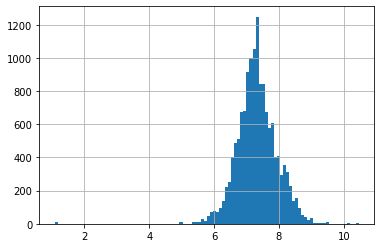

In [76]:
gold_train['primary_cleaner_input_feed_size'].hist(bins=100)
gold_train['primary_cleaner_input_feed_size'].describe()

count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner_input_feed_size, dtype: float64

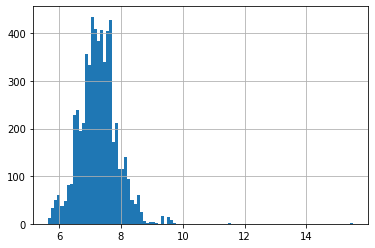

In [77]:
gold_test['primary_cleaner_input_feed_size'].hist(bins=100)
gold_test['primary_cleaner_input_feed_size'].describe()

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher_input_feed_size, dtype: float64

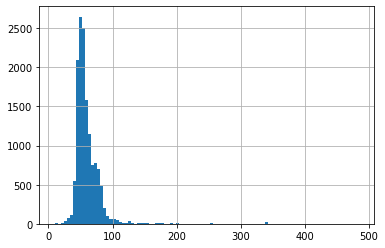

In [78]:

gold_train['rougher_input_feed_size'].hist(bins=100)
gold_train['rougher_input_feed_size'].describe()

count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rougher_input_feed_size, dtype: float64

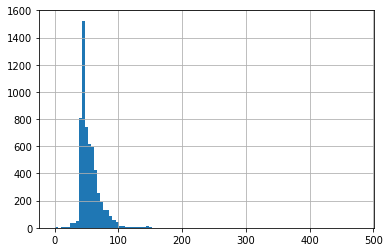

In [79]:
gold_test['rougher_input_feed_size'].hist(bins=100)
gold_test['rougher_input_feed_size'].describe()

After analyzing the histograms above and looking at mean, median and standard deviation for both metrics in both data sets I can confidently say that the distributions don't vary significantly between both sets so we can continue with our project. 

### 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. 
Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.  <a id='2.3'></a>


[Back to Contents](#back)

### Freatures we will look at:

final_output_concentrate_ag                               
final_output_concentrate_pb                            
final_output_concentrate_sol                            
final_output_concentrate_au

rougher_output_concentrate_ag                             
rougher_output_concentrate_pb                          
rougher_output_concentrate_sol                     
rougher_output_concentrate_au  

primary_cleaner_output_concentrate_ag                 
primary_cleaner_output_concentrate_pb                      
primary_cleaner_output_concentrate_sol                     
primary_cleaner_output_concentrate_au

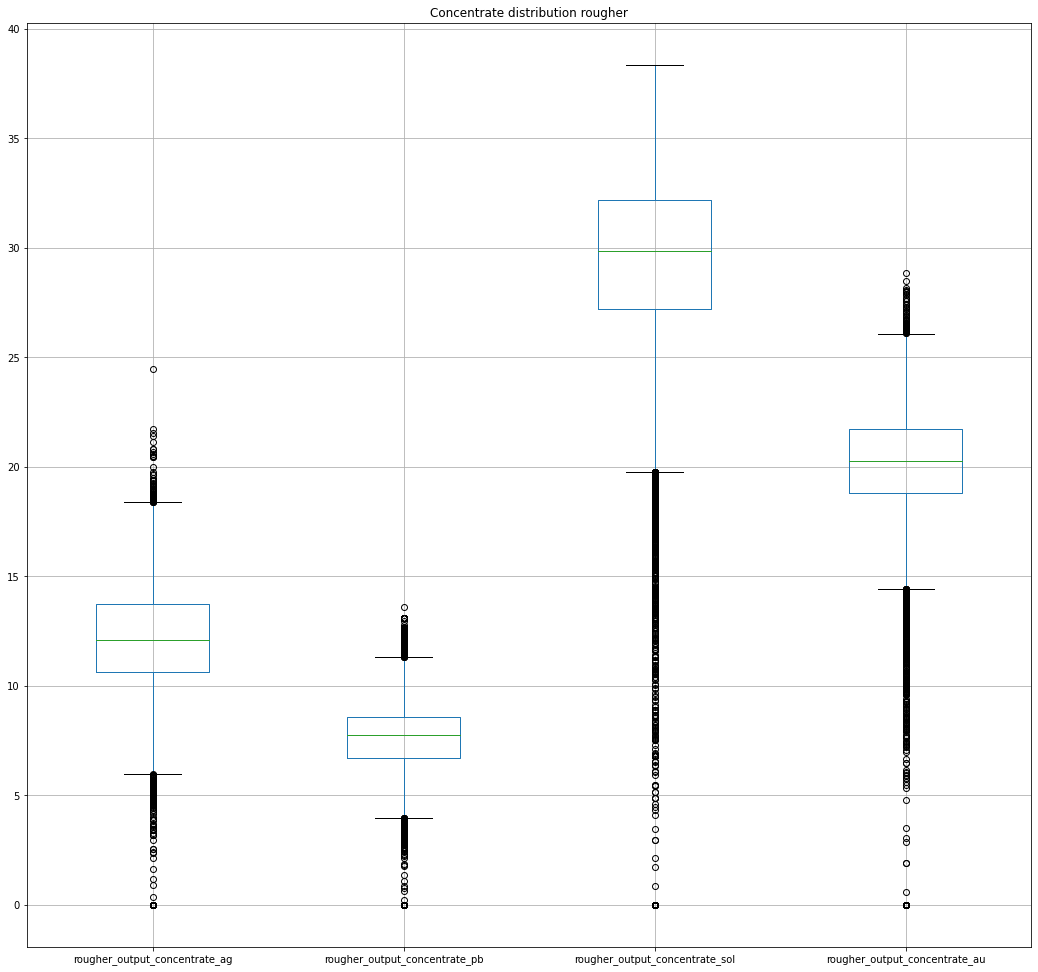

In [80]:
plt.subplots(figsize=(18,17)) #Drawing boxplots and histograms since they will help visually look for outliers
gold_full.loc[:,['rougher_output_concentrate_ag',
'rougher_output_concentrate_pb','rougher_output_concentrate_sol','rougher_output_concentrate_au']].boxplot()
plt.title('Concentrate distribution rougher')
plt.show()

In [81]:
gold_full.loc[:,['rougher_output_concentrate_ag',
'rougher_output_concentrate_pb','rougher_output_concentrate_sol','rougher_output_concentrate_au']].describe()

,rougher_output_concentrate_ag,rougher_output_concentrate_pb,rougher_output_concentrate_sol,rougher_output_concentrate_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,11.994759,7.606272,28.797834,19.772000
std,2.733862,1.796757,5.957337,3.753600
min,0.000000,0.000000,0.000000,0.000000
25%,10.628337,6.725987,27.221408,18.802523
50%,12.098115,7.742580,29.833638,20.280214
75%,13.736996,8.565199,32.189139,21.717843
max,24.480271,13.617072,38.351193,28.824507


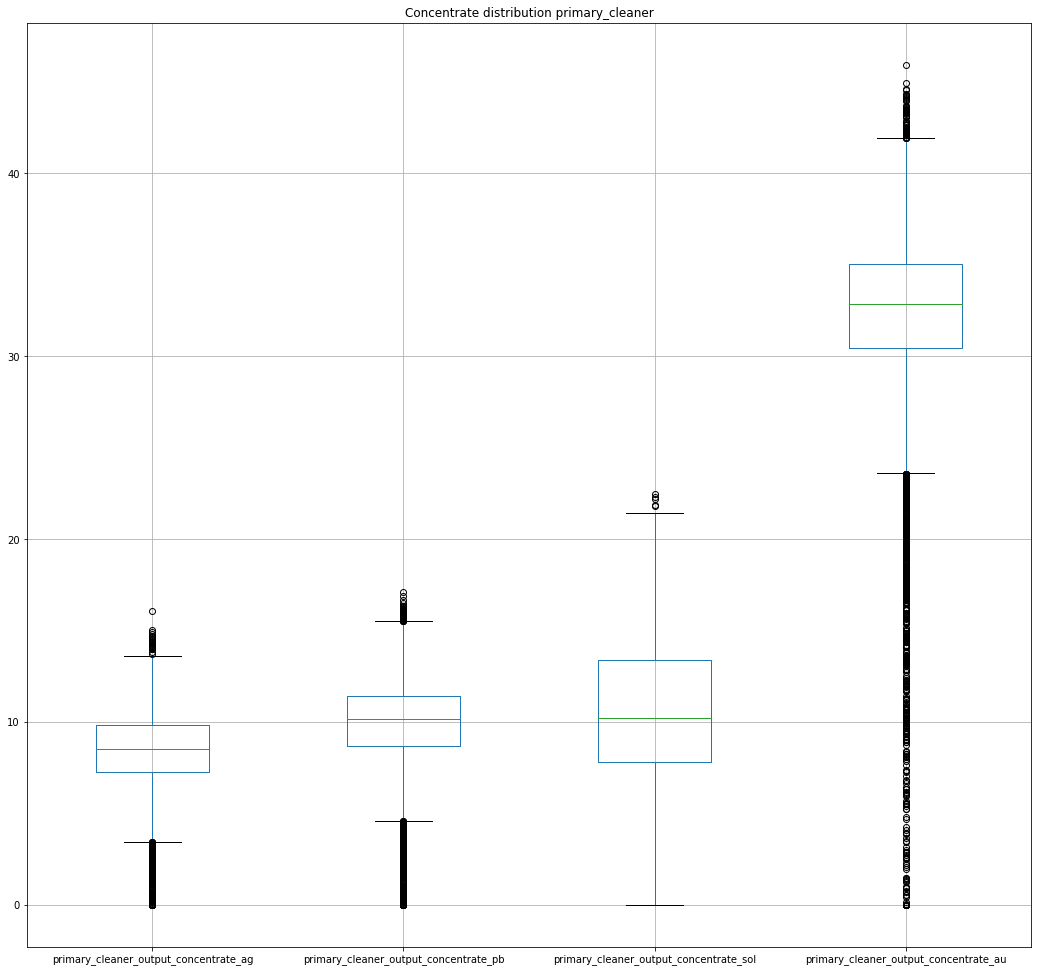

In [82]:
plt.subplots(figsize=(18,17))
gold_full.loc[:,['primary_cleaner_output_concentrate_ag',
'primary_cleaner_output_concentrate_pb','primary_cleaner_output_concentrate_sol','primary_cleaner_output_concentrate_au']].boxplot()
plt.title('Concentrate distribution primary_cleaner')
plt.show()

In [83]:
gold_full.loc[:,['primary_cleaner_output_concentrate_ag',
'primary_cleaner_output_concentrate_pb','primary_cleaner_output_concentrate_sol','primary_cleaner_output_concentrate_au']].describe()

,primary_cleaner_output_concentrate_ag,primary_cleaner_output_concentrate_pb,primary_cleaner_output_concentrate_sol,primary_cleaner_output_concentrate_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,8.442408,9.810317,10.392606,32.119400
std,2.054465,2.572253,3.969018,5.627611
min,0.000000,0.000000,0.000000,0.000000
25%,7.263288,8.676500,7.788574,30.463140
50%,8.507298,10.142270,10.238614,32.841295
75%,9.809001,11.416298,13.394667,35.048006
max,16.081632,17.081278,22.458114,45.933934


In [84]:
gold_train.shape

(14149, 87)

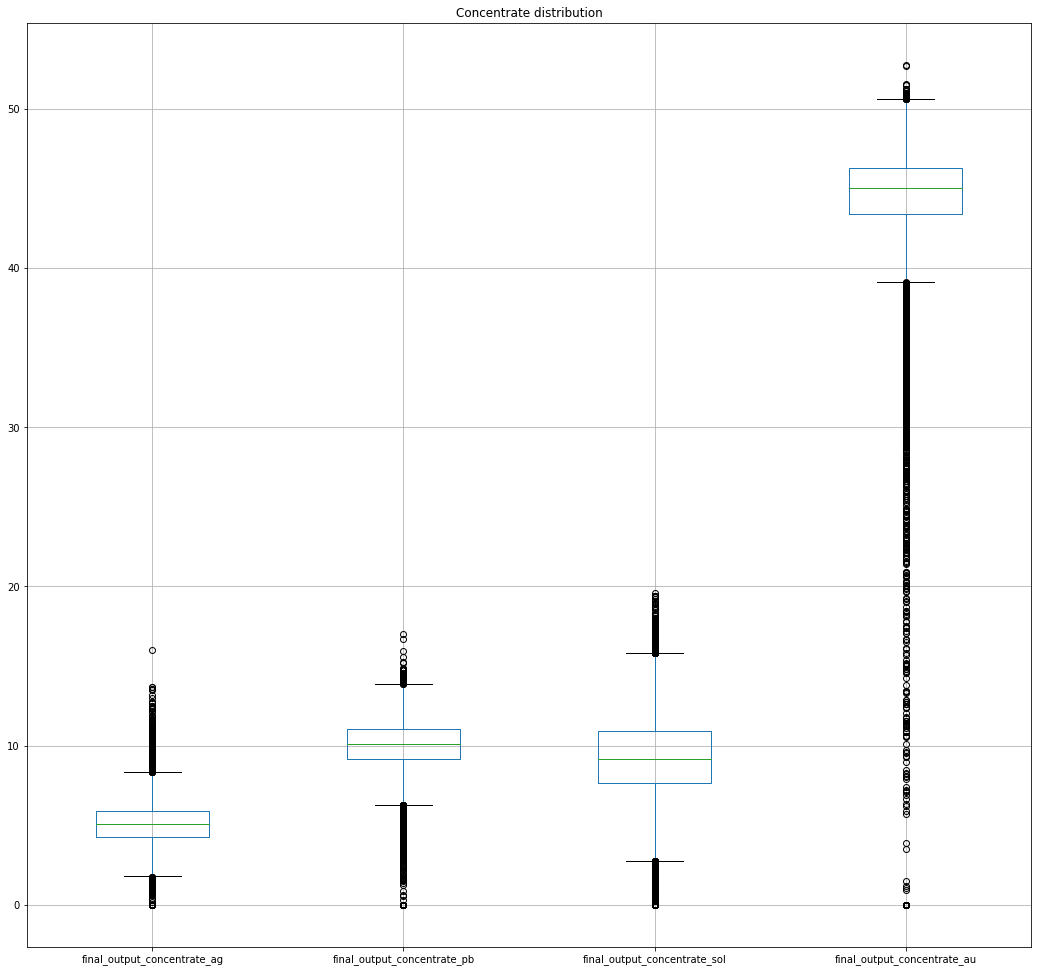

In [85]:
plt.subplots(figsize=(18,17))
gold_full.loc[:,['final_output_concentrate_ag',
'final_output_concentrate_pb','final_output_concentrate_sol','final_output_concentrate_au']].boxplot()
plt.title('Concentrate distribution')
plt.show()

In [86]:
gold_full.loc[:,['final_output_concentrate_ag',
'final_output_concentrate_pb','final_output_concentrate_sol','final_output_concentrate_au']].describe()

,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au
count,19439.000000,19439.000000,19439.000000,19439.000000
mean,5.168387,9.978821,9.429902,44.076513
std,1.372362,1.669228,2.865629,5.129784
min,0.000000,0.000000,0.000000,0.000000
25%,4.251000,9.137225,7.662953,43.402215
50%,5.066039,10.102264,9.184826,45.011244
75%,5.895401,11.035644,10.920957,46.275313
max,16.001945,17.031899,19.615720,52.756638


#### Interim Conclusions: Looking at just the boxplots it would seem that the data has a serious problem with outliers but when you look at the mean and median we can see that outliers are not skewing the data too much. The max values are not more than 3 standard deviations from the mean and median. I will draw some histograms below to drive the point home. 

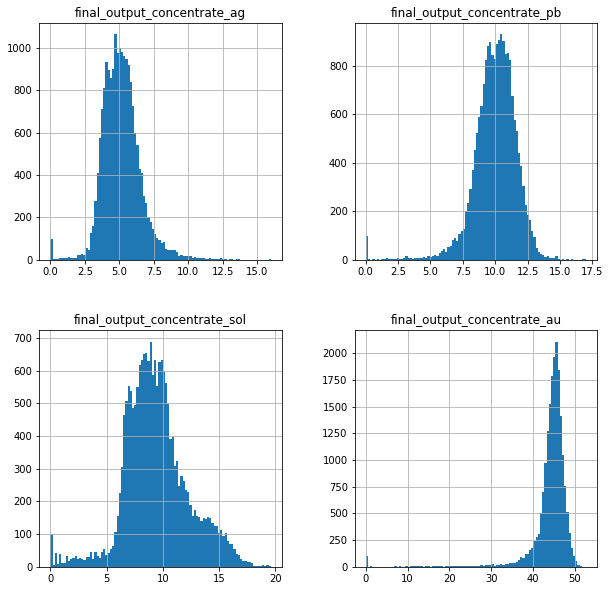

In [87]:

gold_full.loc[:,['final_output_concentrate_ag',
'final_output_concentrate_pb','final_output_concentrate_sol','final_output_concentrate_au']].hist(bins=100,figsize=(10,10))

plt.show()

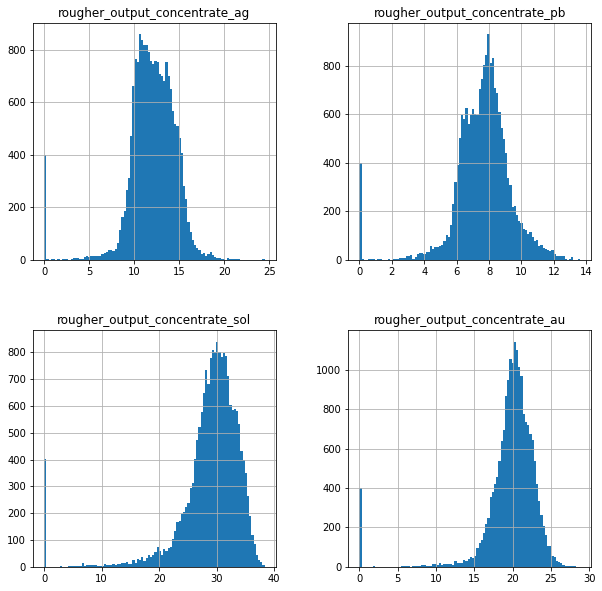

In [88]:
gold_full.loc[:,['rougher_output_concentrate_ag',
'rougher_output_concentrate_pb','rougher_output_concentrate_sol','rougher_output_concentrate_au']].hist(bins=100,figsize=(10,10))

plt.show()

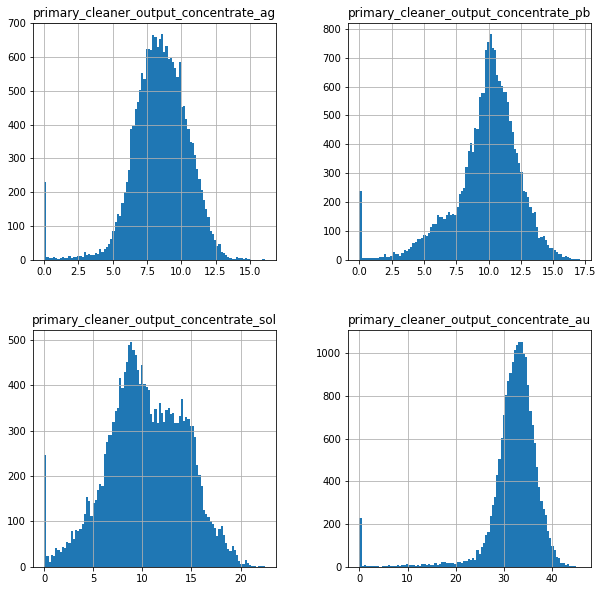

In [89]:
gold_full.loc[:,['primary_cleaner_output_concentrate_ag',
'primary_cleaner_output_concentrate_pb','primary_cleaner_output_concentrate_sol','primary_cleaner_output_concentrate_au']].hist(bins=100,figsize=(10,10))

plt.show()

### Interim Conclusions: I took the full data set since it contains both test and train set. There are some values of zero even in the gold concentrate but I don't think we should remove them or delete them since we want the model to be able to correctly identify and predict when we will have zero gold recovery. 

In [90]:
target = ['rougher_output_recovery', 'final_output_recovery']
print(target.index('rougher_output_recovery'))
print(target.index('final_output_recovery'))

0
1


## 3 Build the model  <a id='3.0'></a>
[Back to Contents](#back)

### 3.1. Write a function to calculate the final sMAPE value. <a id='3.1'></a>

[Back to Contents](#back)

In [91]:
def smape(y_true, y_pred): #define a fuction to calculate smape
    frac = np.abs(y_true - y_pred) / ((np.abs(y_true)+np.abs(y_pred))/2)
    return np.mean(frac, axis=0)

In [92]:
def smape_final(y_true,y_pred): #def a fuction to calculate final smape that uses prev fuction
    smape_rougher = smape(y_true[:,target.index('rougher_output_recovery')], y_pred[:,target.index('rougher_output_recovery')])
    smape_final = smape(y_true[:,target.index('final_output_recovery')], y_pred[:,target.index('final_output_recovery')])
    return 0.25*smape_rougher + 0.75*smape_final

In [93]:
smape_score = make_scorer(smape_final, greater_is_better=False) #make smape_final a scorer to pass to cross validation functions

### The first thing we need to do is bring in the targets for the test set from the full set linking on date.

In [94]:
test_dates = gold_test['date']

In [95]:
test_dates

0      2016-09-01 00:59:59
1      2016-09-01 01:59:59
2      2016-09-01 02:59:59
3      2016-09-01 03:59:59
4      2016-09-01 04:59:59
               ...        
5851   2017-12-31 19:59:59
5852   2017-12-31 20:59:59
5853   2017-12-31 21:59:59
5854   2017-12-31 22:59:59
5855   2017-12-31 23:59:59
Name: date, Length: 5856, dtype: datetime64[ns]

In [96]:
new_gold_test = gold_full.query('date in @test_dates') #Getting all features to test the model since the training was done on all features

In [97]:
display(new_gold_test.shape) #New test set has all 87 features
display(gold_test.shape)
display(gold_full.shape)

(5290, 87)

(5856, 53)

(19439, 87)

In [98]:
gold_train.head()

,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [99]:
features = list(set(gold_train.columns).intersection(set(gold_test.columns)).difference(set(target)))
display(len(features))
features.remove('date') #dropping date for training and testing models since it is an unique index for each row
display(len(features))
print(features)

53

52

['rougher_state_floatbank10_f_level', 'primary_cleaner_state_floatbank8_a_level', 'primary_cleaner_state_floatbank8_a_air', 'primary_cleaner_input_sulfate', 'secondary_cleaner_state_floatbank5_a_level', 'rougher_state_floatbank10_e_level', 'rougher_input_floatbank11_xanthate', 'rougher_input_feed_sol', 'primary_cleaner_state_floatbank8_c_air', 'primary_cleaner_state_floatbank8_d_level', 'rougher_state_floatbank10_a_air', 'primary_cleaner_input_feed_size', 'secondary_cleaner_state_floatbank2_a_level', 'secondary_cleaner_state_floatbank4_a_air', 'secondary_cleaner_state_floatbank6_a_air', 'secondary_cleaner_state_floatbank2_b_level', 'secondary_cleaner_state_floatbank5_a_air', 'primary_cleaner_input_xanthate', 'secondary_cleaner_state_floatbank4_b_air', 'primary_cleaner_state_floatbank8_d_air', 'rougher_state_floatbank10_b_level', 'rougher_state_floatbank10_c_level', 'primary_cleaner_state_floatbank8_b_air', 'secondary_cleaner_state_floatbank5_b_air', 'rougher_input_feed_ag', 'rougher_in

In [100]:
gold_test.shape

(5856, 53)

In [101]:
len(features)

52

In [102]:
gold_train = gold_train.dropna()
gold_test = gold_test.dropna()


In [103]:
#Creating the training/testing features and targets
X_train, X_test = gold_train[features].values, new_gold_test[features].values
y_train, y_test = gold_train[target].values, new_gold_test[target].values

### 3.2 Creating a DummyRegressor to act as a sanity check and a baseline for our ML models. If we can't beat this sMAPE score that just takes the mean for all targets then we don't have a very good model.  <a id='3.2'></a>


[Back to Contents](#back)

### 3.2 Dummy Regressor
[Back to Contents](#back)

In [104]:
dm = DummyRegressor(strategy='mean').fit(X_train, y_train)
y_pred = dm.predict(X_test)
print('smape:', smape_final(y_test, y_pred))

smape: 0.10289630376021036


### 3.3 LinearRegression  <a id='3.3'></a>

[Back to Contents](#back)

In [105]:
lr = LinearRegression().fit(X_train, y_train)
scores_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring=smape_score)
print("mean smape:", scores_lr.mean())
scores_lr

mean smape: -0.12384596104847154


array([-0.14402642, -0.09993082, -0.12746867, -0.11501761, -0.13278628])

### 3.4  RandomForestRegressor  <a id='3.4'></a>

[Back to Contents](#back)

In [106]:
#Do the same for RandomForestRegressor
rfr_model = RandomForestRegressor(random_state = 2023)

search_space_rfr = {'n_estimators': (5,10),"max_depth" : [ 3,6,12]
                    } #This will be used to try differnet depths and estimators in the randomforest

In [107]:
G_S_rfr = GridSearchCV(estimator = rfr_model, #RandomForrestRegressor
                  param_grid = search_space_rfr, #change the search_space variable for rfr
                  scoring=smape_score,
                  cv = 5, #cross validation set to 5
                  verbose = 4) 

In [108]:
G_S_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....................max_depth=3, n_estimators=5; total time=   1.2s
[CV 2/5] END ....................max_depth=3, n_estimators=5; total time=   0.8s
[CV 3/5] END ....................max_depth=3, n_estimators=5; total time=   0.8s
[CV 4/5] END ....................max_depth=3, n_estimators=5; total time=   0.9s
[CV 5/5] END ....................max_depth=3, n_estimators=5; total time=   0.8s
[CV 1/5] END ...................max_depth=3, n_estimators=10; total time=   1.7s
[CV 2/5] END ...................max_depth=3, n_estimators=10; total time=   1.7s
[CV 3/5] END ...................max_depth=3, n_estimators=10; total time=   1.7s
[CV 4/5] END ...................max_depth=3, n_estimators=10; total time=   1.7s
[CV 5/5] END ...................max_depth=3, n_estimators=10; total time=   1.7s
[CV 1/5] END ....................max_depth=6, n_estimators=5; total time=   1.6s
[CV 2/5] END ....................max_depth=6, n_e

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2023),
             param_grid={'max_depth': [3, 6, 12], 'n_estimators': (5, 10)},
             scoring=make_scorer(smape_final, greater_is_better=False),
             verbose=4)

In [109]:
G_S_rfr.best_score_ #if a tree is good normally a forest is better!

-0.1051723240075478

In [110]:
display(G_S_rfr.best_params_)
best_params = G_S_rfr.best_params_

{'max_depth': 6, 'n_estimators': 10}

In [111]:
rfr = RandomForestRegressor(**best_params).fit(X_train, y_train) #pass on the best params
scores_rfr = cross_val_score(rfr, X_train, y_train, cv=5, scoring=smape_score)

print("mean smape:", scores_rfr.mean())
scores_rfr

mean smape: -0.1032567493277764


array([-0.09677851, -0.08862505, -0.1147238 , -0.11490247, -0.10125392])

#### The cross validation improved the sMAPE score but still the LR model seems to be much better.

In [113]:
#Not necessary to do cross validation since we already did this with the training set to get the best hyperparameters.
rfr = RandomForestRegressor(**best_params).fit(X_train, y_train) #pass on the best params and fit with train data set
y_pred_rfr = rfr.predict(X_test)
smape_final(y_test, y_pred_rfr ) #Getting the final sMAPE score

0.09441119328544981

## Final Conclusions:  <a id='end'></a>


  [Back to Contents](#back)  


### The best model in now the RandomForestRegressor but it's not much better than the DummyRegressor so I wouldn't feel very confident sharing this  ML model with Zyfra.  But at the very least it's better than just predicting the mean every time so they might be ok with it and they might actually use it to make predictions of gold recovery.  

### The mean sMAPE scores for each model are as follows:

    DummyRegressor(strategy='mean') = 0.10
    LinearRegression() =              0.12 (ignoring the negative sign per sklearn documentation).
    
    RandomForrestRegressor() =        0.09 (with test set)
    
    
### We can here  see the best  sMAPE score is now for the RandomForrestRegressor when using test set.
